In this tutorial notebook, we will go through a simple example of applying RETINA on Perez dataset. This script can be easily run locally without using much computational power. 

The example images we use are in the same directory including the image and the label. 
Since it needs the fine-tuned parameters, we uploaded the file: '/RETINA/perez_lyso/checkpoint/epoch_2500.pth', which can be found in the google drive tutorial model directory.

In [2]:
import os, sys, argparse, warnings, cv2, yaml
import numpy as np
import torch
import torch.nn as nn
from skimage import io
from skimage import measure
from glob import glob
from tqdm import tqdm
from torch.utils.data import DataLoader

from albumentations import Compose, Normalize
from albumentations.pytorch import ToTensorV2
from copy import deepcopy
from datasets.dataset_synapse import SegmentationData
from PIL import Image

from monai.inferers import sliding_window_inference
from networks.vit_seg_modeling import VisionTransformer as ViT_seg
from networks.vit_seg_modeling import CONFIGS as CONFIGS_ViT_seg

'''
    This is a small example of how to run the inference with the trained parameters
    We ran this locally instead of the server.
    We took the example of lysosome in Perez dataset.
'''
def mean_iou(output, target):
    if target.ndim == output.ndim - 1:
        target = target.unsqueeze(1)
    n_classes = output.size(1)
    empty_dims = (1,) * (target.ndim - 2)

    if n_classes > 1:
        k = torch.arange(0, n_classes).view(1, n_classes, *empty_dims).to(target.device)
        target = (target == k)

        #softmax the output
        output = nn.Softmax(dim=1)(output)
    else:
        #just sigmoid the output
        output = (nn.Sigmoid()(output) > 0.5).long()
    target = target.type(output.dtype)

    dims = (0,) + tuple(range(2, target.ndim))
    intersect = torch.sum(output * target, dims)

    union = torch.sum(output + target, dims) - intersect

    iou = (intersect + 1e-7) / (union + 1e-7)

    return iou.mean().item()

if __name__ == '__main__':
    with open("/RETINA/perez_lyso/perez_lyso.yaml", 'r') as f:
        config = yaml.load(f, Loader=yaml.FullLoader)

    test_dir = '/RETINA/example/2d'
    
    # this should be replaced by your trained one.
    state_path = "/RETINA/perez_lyso/checkpoint/iteration_2500.pth"
    threshold = None

    if threshold is None:
        threshold = 0.5
    
    eval_classes = config['eval_classes2d']
    if config['experiment_name'][:5] == 'perez':
        
        instance_match = config['instance_match2d']
    else:
        instance_match = None
    state = torch.load(state_path, map_location='cpu')
    if 'run_id' in state:
        run_id = state['run_id']
    else:
        run_id = None
    
    norms = config['norms']
    print(norms)

    gray_channels = 1
    num_classes = config['num_classes']
    print("numclass:", num_classes)
    if eval_classes is None:
        if num_classes == 1:
            eval_classes = [1]
        else:
            eval_classes = list(range(1, num_classes))
    eval_tfs = Compose([
        Normalize(mean=norms['mean'], std=norms['std']),
        ToTensorV2()
    ])

    #create the dataset and dataloader
    test_data = SegmentationData(test_dir, tfs=eval_tfs)
    test = DataLoader(test_data, batch_size=1, shuffle=False, pin_memory=True, num_workers=4)
    inference_only = False
    config_vit = CONFIGS_ViT_seg['R50-ViT-B_16']
    config_vit.n_classes = num_classes
    config_vit.n_skip = 3
    config_vit.mlp_ratio = 4
    config_vit.transformer.num_layers = config['transformer_layer']
    if config['pretrain'] == 'imagenet' or config['pretrain'] == 'incem':
        print(config['pretrain'])
        config_vit.hidden_size = 768
        config_vit.transformer.num_heads = 12
        config_vit.transformer.mlp_dim = 3072
    if 'R50-ViT-B_16' != -1:
        config_vit.patches.grid = (int(224 / 16), int(224 / 16))
    config_vit = CONFIGS_ViT_seg['R50-ViT-B_16']
    model = ViT_seg(config_vit, img_size=224, num_classes=config_vit.n_classes)
    state_new = {k.replace('module.', ''): v for k, v in state.items()}
    model.load_state_dict(state_new)
    
    
    #set the model to eval mode
    model.eval()
    
    #loop over the images, predict, save, compute iou
    image_ious = []
    num = 0 
    for data in test:
        num = num + 1
        #load image to gpu
        image = data['image']#(1, 1, H', W')
        mask = data['mask']
        with torch.no_grad():
            prediction = sliding_window_inference(image, (224, 224), 4, model, overlap=0.5).detach()
            if num_classes == 1:
                #(1, 1, H, W) --> (H, W)
                prediction = (nn.Sigmoid()(prediction) > threshold).squeeze().cpu().numpy()
                prediction_img = (prediction * 255).astype(np.uint8)
            else:
                prediction = nn.Softmax(dim=1)(prediction) #(1, C, H, W)
                prediction = torch.argmax(prediction, dim=1) #(1, H, W)
                prediction = prediction.squeeze().cpu().numpy() #(H, W)
        if not inference_only:
            mask = data['mask'].squeeze().numpy()  #(1, H, W) --> (H, W)
            
            class_ious = []
            for label in eval_classes:
                label_mask = mask == label
                label_pred = prediction == label
                
                #there's 1 hiccup to consider that occurs
                #when not all of the instances of an object
                #are labeled in a 2d image. this is the case for all
                #the datasets in the Perez benchmark (e.g. there may be
                #20 mitochondria in an image, but only 10 were labeled).
                #to handle this case we'll need to only consider parts of the
                #prediction that have some overlap with the ground truth. in
                #principle this will hide some instances that are FP, but it will
                #not hide FP pixels that were predicted as part of an instance
                if instance_match:

                    instance_label_mask = measure.label(label_mask)
                    instance_label_pred = measure.label(label_pred)

                    instance_matched_prediction = np.zeros_like(label_pred)
                    mask_instance_labels = np.unique(instance_label_mask)[1:]
                    for mask_instance_label in mask_instance_labels:
                        #find all the instance labels in the prediction that 
                        #coincide with the current mask instance label
                        prediction_instance_labels = np.unique(
                            instance_label_pred[instance_label_mask == mask_instance_label]
                        )

                        #add all pixels in the prediction with the detected instance
                        #labels to the instance_matched_prediction
                        for prediction_instance_label in prediction_instance_labels:
                            if prediction_instance_label != 0: #ignore background
                                instance_matched_prediction += instance_label_pred == prediction_instance_label

                    #alright, now finally, we can compare the label_mask and the instance_matched_prediction
                    intersect = np.logical_and(instance_matched_prediction, label_mask).sum()
                    union = np.logical_or(instance_matched_prediction, label_mask).sum()
                
                else:
                    #this is the case that we hope to find ourselves in.
                    #evaluation is much easier here
                    intersect = np.logical_and(label_pred, label_mask).sum()
                    union = np.logical_or(label_pred, label_mask).sum()
                
                class_ious.append((intersect + 1e-5) / (union + 1e-5)) # iou for each class (label) of the current image

            image_ious.append(class_ious) # every value in image_ious is a list with iou of each class


    
    #report the mean IoU
    if not inference_only:
        image_ious = np.array(image_ious)
        mean_class_ious = image_ious.mean(axis=0)
        for label, mci in zip(eval_classes, mean_class_ious):
            print(f'Class {label} IoU 2d: {mci}')
        #print the overall mean
        mean_iou = image_ious.mean()
        print(f'Mean IoU: {mean_iou}')

{'mean': 0.35047498, 'std': 0.01674651}
numclass: 1
Found 1 images in /home/codee/scratch/RETINA/example/2d/images
Class 1 IoU 2d: 0.8903263749181818
Mean IoU: 0.8903263749181818


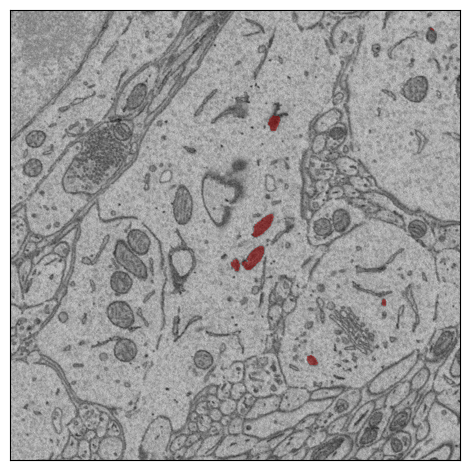

In [24]:
'''
This is the predicted segmentation result from RETINA
'''
from matplotlib import pyplot as plt
from skimage import io
mask = Image.fromarray(prediction)
mask = np.array(mask)

mask = mask.astype(bool)
image = io.imread("/RETINA/example/2d/images/000.png")
fig, ax = plt.subplots()
plt.imshow(image, cmap='gray')
overlay = np.zeros((*image.shape, 4))
overlay[mask == True, :] = [1, 0, 0, 0.3] 
ax.imshow(overlay, interpolation='nearest')

ax.set_xticks([])  
ax.set_yticks([])
plt.tight_layout()

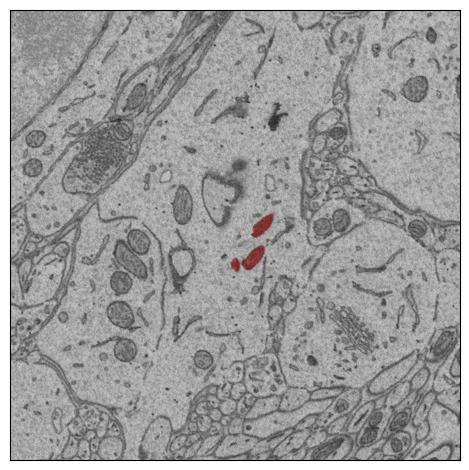

In [25]:
'''
This shows the ground truth.
Note: the ground truth of Perez dataset was only partially labeled.
'''

image = io.imread("/RETINA/example/2d/images/000.png")
mask = io.imread("/RETINA/example/2d/masks/000.png")
fig, ax = plt.subplots()
plt.imshow(image, cmap='gray')
overlay = np.zeros((*image.shape, 4)) 
overlay[mask == 1, :] = [1, 0, 0, 0.3] 
ax.imshow(overlay, interpolation='nearest')
ax.set_xticks([])  
ax.set_yticks([])
plt.tight_layout()
